# Working with Text Data
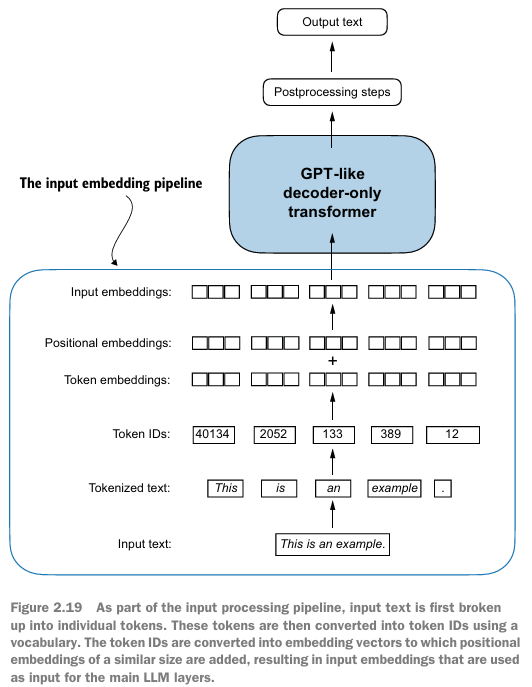

In [1]:
# load the data
import os
import urllib.request

url = ("https://raw.githubusercontent.com/ArsalanMateen/Mahir-on-Call/refs/heads/main/working-with-text-data/roman-urdu-corpus.txt")
file_path = "roman-urdu-corpus.txt"
urllib.request.urlretrieve(url, file_path)

('roman-urdu-corpus.txt', <http.client.HTTPMessage at 0x7c579b60a060>)

In [2]:
with open("roman-urdu-corpus.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
print("The total number of character:", len(raw_text))

The total number of character: 9843914


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1 (Dataset):
    def __init__(self, raw_text, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # tokenization using byte pair encoding
        token_ids = tokenizer.encode(raw_text, allowed_special={"<|endoftext|"})

        # data sampling using sliding window
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i+1:i + max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [4]:
import tiktoken

def create_dataloader_v1(raw_text,
                         batch_size,
                         max_length,
                         stride,
                         shuffle = True,
                         drop_last = True,
                         num_workers = 0):


    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(raw_text, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

In [5]:
vocab_size = 50257
output_dim = 768

torch.manual_seed(123)

# Initialize token embedding layer
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [10]:
batch_size = 8
max_length = 1024
dataloader = create_dataloader_v1(
    raw_text,
    batch_size=batch_size,
    max_length=max_length,
    stride=max_length,
    shuffle=True,
    drop_last=True,
    num_workers=0
)

In [11]:
context_length = max_length
# Initialize position embedding layer
position_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [12]:
# creating input embeddings
for batch in dataloader:
    input_ids, target_ids = batch

    token_embeddings = token_embedding_layer(input_ids)
    position_embeddings = position_embedding_layer(torch.arange(context_length))

    input_embeddings = token_embeddings + position_embeddings

    break

In [13]:
print(input_embeddings.shape)

torch.Size([8, 1024, 768])
